In [ ]:
# import os
# path = r"C:\Users\32005\Desktop\手写数字\9"

# files = os.listdir(path)#原来文件夹的路径
# i = 0

# for file in files:
#     original = r"C:\Users\32005\Desktop\手写数字\9" + os.sep + files[i]
#     #修改后放置图片的路径 F:/ns，也可将 img_ 换成其他标注
#     new = r"C:\Users\32005\Desktop\手写数字\9" + os.sep + "j" + str(i + 1) + "_label_9.jpg"
#     os.rename(original, new)
#     i += 1

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#数据预处理" data-toc-modified-id="数据预处理-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>数据预处理</a></span><ul class="toc-item"><li><span><a href="#opencv读取图片文件" data-toc-modified-id="opencv读取图片文件-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>opencv读取图片文件</a></span></li></ul></li><li><span><a href="#建立模型" data-toc-modified-id="建立模型-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>建立模型</a></span></li><li><span><a href="#进行训练" data-toc-modified-id="进行训练-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>进行训练</a></span></li><li><span><a href="#模型准确性" data-toc-modified-id="模型准确性-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>模型准确性</a></span></li><li><span><a href="#进行预测" data-toc-modified-id="进行预测-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>进行预测</a></span></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 支持多行输出
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'

#   数据预处理

## opencv读取图片文件

In [ ]:
# import cv2
# import numpy as np
# import os

# df = pd.read_csv('label.txt',header=None, sep=' ',index_col=0,names=['filename','num'])
# label = df.to_dict('index')

# baseDir = "imgdata"  # 读取文件的路径
# filenames = os.listdir(baseDir)
# imgdata = cv2.imread('imgdata/' + list(label.keys())[0], flags=1)
# imgdata = cv2.resize(imgdata, (64, 64))
# imgdata = imgdata.reshape(1,64,64,3)

# #定义标签列表
# y_train = []
# for i in label:
#     y_train.append(label[i].get('num'))
#     if i != list(label.keys())[0]:
#         imgfile = 'imgdata/' + i
#         tmp_img = cv2.imread(imgfile, flags=1)
#         tmp_img = cv2.resize(tmp_img, (64, 64))
#         tmp_img = tmp_img.reshape(1,64,64,3)
#         imgdata = np.concatenate((imgdata, tmp_img), axis=0)

# X_train = imgdata
# X_train_normalize = X_train.astype('float32') / 255.0

# y_train = np.array(y_train)
# X_train.shape

In [2]:
import numpy as np
from tensorflow.keras.datasets import mnist
(X_train,y_train),(x_test,y_test) = mnist.load_data()

X_train_normalize = X_train.astype('float32') / 255.0
X_train_normalize4D = X_train_normalize.reshape(60000,28,28,1)
y_train = np.array(y_train)

In [31]:
# X_train_normalize4D

In [4]:
from tensorflow.keras.utils import to_categorical
y_train_oh = to_categorical(y_train)
y_train_oh[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [5]:
y_train_oh

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [6]:
X_train_normalize4D.shape

(60000, 28, 28, 1)

In [ ]:
# index = [i for i in range(len(X_train))]
# np.random.shuffle(index)
# X_train = X_train[index]
# y_train = y_train[index]

# 建立模型

In [7]:
import tensorflow.keras as keras
model = keras.models.Sequential()

#卷积层1
model.add(keras.layers.Conv2D(
                 filters=8,    
                 kernel_size=(3,3),
                 input_shape=(28,28,1),            
                 activation='relu')) # strides=(1, 1)是默认值
#池化层1
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

#卷积层2
model.add(keras.layers.Conv2D(
                 filters=16,
                 kernel_size=(3,3),
                 activation='relu'))
#池化层2
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

#卷积层3
model.add(keras.layers.Conv2D(
                 filters=32,
                 kernel_size=(3,3),
                 activation='relu'))
#池化层3
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

#展平层
model.add(keras.layers.Flatten())
#全连接层1
model.add(keras.layers.Dense(128, activation='relu'))
#Dropout
model.add(keras.layers.Dropout(0.5))
#全连接层2
model.add(keras.layers.Dense(10,activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0

# 进行训练

In [8]:
train_history = model.fit(
                        x=X_train_normalize4D, 
                        y=y_train_oh,
                        validation_split=0.2, 
                        epochs=50, 
                        batch_size=20,
                        verbose=1
                        )

Epoch 1/50
2400/2400 [==============================] - 7s 3ms/step - loss: 0.4396 - accuracy: 0.8623 - val_loss: 0.1788 - val_accuracy: 0.9441
Epoch 2/50
2400/2400 [==============================] - 7s 3ms/step - loss: 0.1726 - accuracy: 0.9493 - val_loss: 0.1027 - val_accuracy: 0.9682
Epoch 3/50
2400/2400 [==============================] - 7s 3ms/step - loss: 0.1354 - accuracy: 0.9597 - val_loss: 0.1107 - val_accuracy: 0.9643
Epoch 4/50
2400/2400 [==============================] - 7s 3ms/step - loss: 0.1133 - accuracy: 0.9667 - val_loss: 0.0957 - val_accuracy: 0.9707
Epoch 5/50
2400/2400 [==============================] - 6s 3ms/step - loss: 0.0999 - accuracy: 0.9708 - val_loss: 0.0769 - val_accuracy: 0.9777
Epoch 6/50
2400/2400 [==============================] - 6s 3ms/step - loss: 0.0918 - accuracy: 0.9719 - val_loss: 0.0711 - val_accuracy: 0.9785
Epoch 7/50
2400/2400 [==============================] - 7s 3ms/step - loss: 0.0831 - accuracy: 0.9748 - val_loss: 0.0809 - val_accuracy:

# 模型准确性

In [10]:
scores = model.evaluate(X_train_normalize4D, y_train_oh)
scores[0]
scores[1]

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0299 - accuracy: 0.9948


0.02991926670074463

0.994783341884613

# 进行预测

In [ ]:
path = "./0/j10_label_0.jpg"

In [12]:
from PIL import Image
import numpy as np

def preHandle(path):
    """
    读入图像路径，返回图像的二维数组
    """
    img = Image.open(path)  
    img = img.resize((28,28)).convert('L')
    img = (255-np.array(img))/255.
    return img

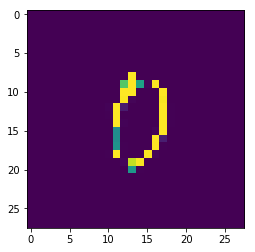

In [13]:
plt.imshow(preHandle("./0/j10_label_0.jpg"))
plt.show()  

In [14]:
x_new = preHandle("./0/j10_label_0.jpg")
x_new.shape

(28, 28)

In [16]:
import os
import numpy as np
path = r"./2/"
files = os.listdir(path)

for i in files:
    file = path + i
    x_new = preHandle(file)
    x_new = x_new.reshape(1,28,28,1)
    predict_x = model.predict(x_new)
    classed_x = np.argmax(predict_x,axis=1)
    
    print(classed_x[0])

3
3
2
5
7
3
3
3
2
9


In [ ]:
import os
import numpy as np
path = r"./2/"
files = os.listdir(path)

for i in files:
    file = path + i
    x_new = preHandle(file)
    x_new = x_new.reshape(1,28,28,1)
    predict_x = model.predict(x_new)
    classed_x = np.argmax(predict_x,axis=1)
    
    print(classed_x[0])

In [29]:
import os
import numpy as np
path = r"./predict/"
files = os.listdir(path)

for i in files:
    file = path + i
    print(file)
    print("真实值是："+file[10])
    x_new = preHandle(file)
    x_new = x_new.reshape(1,28,28,1)
    predict_x = model.predict(x_new)
    classed_x = np.argmax(predict_x,axis=1)
    
    print("预测值是：" +str(classed_x[0]))
    print()

./predict/0_1.png
真实值是：0
预测值是：8

./predict/0_10.png
真实值是：0
预测值是：6

./predict/0_2.png
真实值是：0
预测值是：8

./predict/0_3.png
真实值是：0
预测值是：8

./predict/0_4.png
真实值是：0
预测值是：0

./predict/0_5.png
真实值是：0
预测值是：6

./predict/0_6.png
真实值是：0
预测值是：6

./predict/0_7.png
真实值是：0
预测值是：8

./predict/0_8.png
真实值是：0
预测值是：8

./predict/0_9.png
真实值是：0
预测值是：6

./predict/1_1.png
真实值是：1
预测值是：6

./predict/1_10.png
真实值是：1
预测值是：0

./predict/1_2.png
真实值是：1
预测值是：6

./predict/1_3.png
真实值是：1
预测值是：0

./predict/1_4.png
真实值是：1
预测值是：6

./predict/1_5.png
真实值是：1
预测值是：0

./predict/1_6.png
真实值是：1
预测值是：0

./predict/1_7.png
真实值是：1
预测值是：0

./predict/1_8.png
真实值是：1
预测值是：0

./predict/1_9.png
真实值是：1
预测值是：0

./predict/2_1.png
真实值是：2
预测值是：8

./predict/2_10.png
真实值是：2
预测值是：8

./predict/2_2.png
真实值是：2
预测值是：2

./predict/2_3.png
真实值是：2
预测值是：8

./predict/2_4.png
真实值是：2
预测值是：8

./predict/2_5.png
真实值是：2
预测值是：0

./predict/2_6.png
真实值是：2
预测值是：8

./predict/2_7.png
真实值是：2
预测值是：3

./predict/2_8.png
真实值是：2
预测值是：8

./predict/2_9.png
真实值是：2
预测值是：8

./predi

In [30]:
import os
import numpy as np
path = r"./imgdata/"
files = os.listdir(path)

for i in files:
    file = path + i
    print(file)
    print("真实值是："+file[-5])
    x_new = preHandle(file)
    x_new = x_new.reshape(1,28,28,1)
    predict_x = model.predict(x_new)
    classed_x = np.argmax(predict_x,axis=1)
    
    print("预测值是：" +str(classed_x[0]))
    print()

./imgdata/j10_label_0.jpg
真实值是：0
预测值是：0

./imgdata/j10_label_1.jpg
真实值是：1
预测值是：1

./imgdata/j10_label_2.jpg
真实值是：2
预测值是：3

./imgdata/j10_label_3.jpg
真实值是：3
预测值是：3

./imgdata/j10_label_4.jpg
真实值是：4
预测值是：1

./imgdata/j10_label_5.jpg
真实值是：5
预测值是：5

./imgdata/j10_label_6.jpg
真实值是：6
预测值是：5

./imgdata/j10_label_7.jpg
真实值是：7
预测值是：7

./imgdata/j10_label_8.jpg
真实值是：8
预测值是：3

./imgdata/j10_label_9.jpg
真实值是：9
预测值是：3

./imgdata/j1_label_0.jpg
真实值是：0
预测值是：9

./imgdata/j1_label_1.jpg
真实值是：1
预测值是：7

./imgdata/j1_label_2.jpg
真实值是：2
预测值是：3

./imgdata/j1_label_3.jpg
真实值是：3
预测值是：3

./imgdata/j1_label_4.jpg
真实值是：4
预测值是：6

./imgdata/j1_label_5.jpg
真实值是：5
预测值是：5

./imgdata/j1_label_6.jpg
真实值是：6
预测值是：6

./imgdata/j1_label_7.jpg
真实值是：7
预测值是：7

./imgdata/j1_label_8.jpg
真实值是：8
预测值是：7

./imgdata/j1_label_9.jpg
真实值是：9
预测值是：7

./imgdata/j2_label_0.jpg
真实值是：0
预测值是：9

./imgdata/j2_label_1.jpg
真实值是：1
预测值是：9

./imgdata/j2_label_2.jpg
真实值是：2
预测值是：2

./imgdata/j2_label_3.jpg
真实值是：3
预测值是：3

./imgdata/j2_label_4.jpg
真实值是：